In [2]:
import matplotlib.pyplot as plt
import numpy as np
from cellpose import models
from cellpose.metrics import average_precision
from stardist.models import StarDist2D
from deepcell.applications import CytoplasmSegmentation, Mesmer
from deepcell.datasets import TissueNet
from csbdeep.utils import normalize
import os


key = 'POtyuCIN.nWwQ1FXgroiE8zKTWLgf5rdqGRJeKQHf'
os.environ.update({"DEEPCELL_ACCESS_TOKEN": key})

In [3]:
tissuenet = TissueNet(version='1.1')
X_test, y_test, meta_test = tissuenet.load_data(split='test')

INFO:root:Checking for cached data
INFO:root:Checking tissuenet_v1-1.zip against provided file_hash...
INFO:root:tissuenet_v1-1.zip with hash cab3b8f242aaee02035557b93546d9dc already available.
INFO:root:Extracting C:\Users\aarus\.deepcell\datasets\tissuenet_v1-1.zip
INFO:root:Successfully extracted C:\Users\aarus\.deepcell\datasets\tissuenet_v1-1.zip into C:\Users\aarus\.deepcell\datasets


In [3]:
print(f'X_test shape: {X_test.shape}\t y_test.shape: {y_test.shape}')

X_test shape: (1324, 256, 256, 2)	 y_test.shape: (1324, 256, 256, 2)


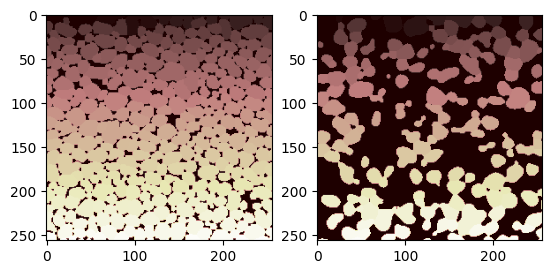

In [16]:
plt.subplot(1,2,1)
plt.imshow(y_test[0,...,0], cmap='pink')
plt.subplot(1,2,2)
plt.imshow(y_test[0,...,1], cmap='pink')

## NUCLEAR SEGMENTATION

- X data, channel 0
- y annotations, channel 1

### Tests with Cellpose

In [31]:
cp_nuclear = models.Cellpose(model_type='nuclei')
masks = [cp_nuclear.eval(x, channels=[1,0], flow_threshold=0.9)[0] for x in X_test] 
cp_predictions = np.array(masks)

INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [1, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.60 sec
INFO:cellpose.models:channels set to [1, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.24 sec
INFO:cellpose.models:channels set to [1, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.27 sec
INFO:cellpose.models:channels set to [1, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.27 sec
INFO:cellpose.models:channels set to [1, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.41 sec
INFO:cellpose.models:channels set to [1, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.22 sec
INFO:cellpose.mo

In [38]:
cp_average_precision = average_precision(y_test[...,1], cp_predictions)

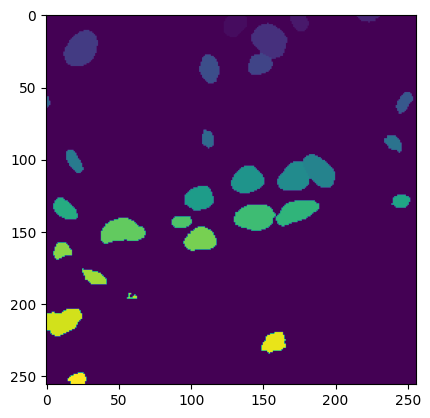

In [36]:
plt.subplot(1,2,1)
plt.imshow(masks[100])
plt.subplot(1,2,2)
plt.imshow(y_test[100,...,1])

In [39]:
print(cp_average_precision)

(array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([135., 135., 135.], dtype=float32), array([1901., 1901., 1901.], dtype=float32))


### Tests with StarDist

In [40]:
sd_nuclear = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [42]:
normalized = [normalize(X_test[i,...,0]) for i in range(X_test.shape[0])]
sd_preds = []
for i, n in enumerate(normalized):
    if i != 286:
        sd_preds.append(sd_nuclear.predict_instances(n)[0])

In [43]:
masks = np.array(sd_preds)
y_test_exclude = np.array([y_test[i,...,1] for i in range(y_test.shape[0]) if i != 286])

In [44]:
sd_ap = average_precision(y_test_exclude, masks)

In [45]:
print(sd_ap)

(array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([267., 267., 267.], dtype=float32), array([1901., 1901., 1901.], dtype=float32))


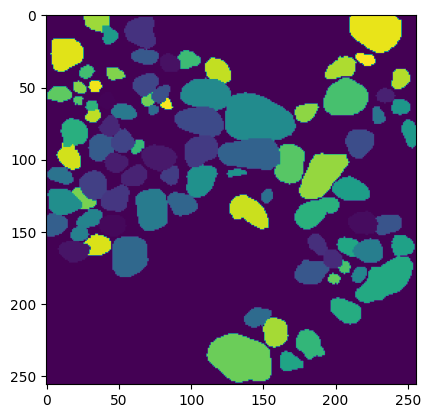

In [46]:
plt.subplot(1,2,1)
plt.imshow(masks[0])
plt.subplot(1,2,2)
plt.imshow(y_test[0,...,1])

### Testing with Mesmer by DeepCell

In [3]:
dp_mesmer = Mesmer()
masks = dp_mesmer.predict(X_test, compartment='nuclear')

INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting C:\Users\aarus\.deepcell\models\MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted C:\Users\aarus\.deepcell\models\MultiplexSegmentation-9.tar.gz into C:\Users\aarus\.deepcell\models


deep_watershed.py (193): Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


In [4]:
dp_ap2 = average_precision(y_test[...,1], masks[...,0])
print(dp_ap2)

(array([0.0008726, 0.       , 0.       ], dtype=float32), array([2., 0., 0.], dtype=float32), array([391., 393., 393.], dtype=float32), array([1899., 1901., 1901.], dtype=float32))


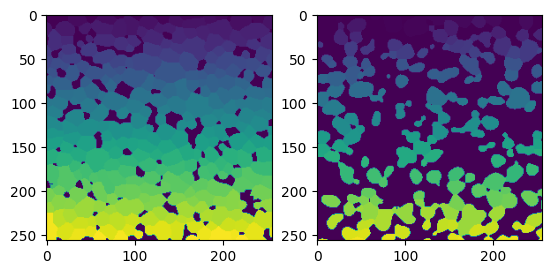

In [5]:
plt.subplot(1,2,1)
plt.imshow(masks[0])
plt.subplot(1,2,2)
plt.imshow(y_test[0,...,1])

## WHOLE-CELL SEGMENTATION

- X data, channel 1
- y annotations, channel 0

### Testing with Cellpose

In [11]:
cp_tissue = models.CellposeModel(model_type='tissuenet_cp3')
masks = [cp_tissue.eval(x, channels=[2,1], flow_threshold=0.8)[0] for x in X_test] 
cp_predictions = np.array(masks)

INFO:cellpose.models:>> tissuenet_cp3 << model set to be used
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.
INFO:cellpose.dynamics:No cell pixels found.


In [16]:
cp_average_precision = average_precision(y_test[...,0], cp_predictions, threshold=[.1, .3, .5, .75, .9])
print(cp_average_precision)

(array([0.03237917, 0.01757632, 0.01476015, 0.00594422, 0.00090992],
      dtype=float32), array([69., 38., 32., 13.,  2.], dtype=float32), array([289., 320., 326., 345., 356.], dtype=float32), array([1773., 1804., 1810., 1829., 1840.], dtype=float32))


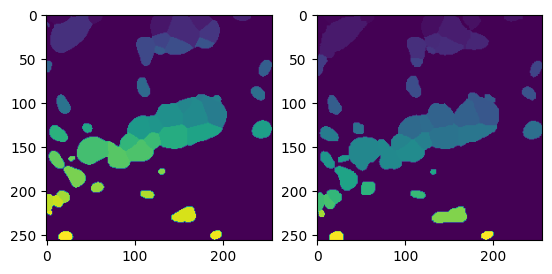

In [17]:
plt.subplot(1,2,1)
plt.imshow(masks[100])
plt.subplot(1,2,2)
plt.imshow(y_test[100,...,0])

Testing with Mesmer

In [4]:
dp_mesmer = Mesmer()
masks = dp_mesmer.predict(X_test, compartment='whole-cell')

INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting C:\Users\aarus\.deepcell\models\MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted C:\Users\aarus\.deepcell\models\MultiplexSegmentation-9.tar.gz into C:\Users\aarus\.deepcell\models


deep_watershed.py (193): Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


In [5]:
masks.shape

(1324, 256, 256, 1)

In [6]:
dp_ap2 = average_precision(y_test[...,0], masks[...,0])
print(dp_ap2)

(array([0.00089326, 0.        , 0.        ], dtype=float32), array([2., 0., 0.], dtype=float32), array([397., 399., 399.], dtype=float32), array([1840., 1842., 1842.], dtype=float32))


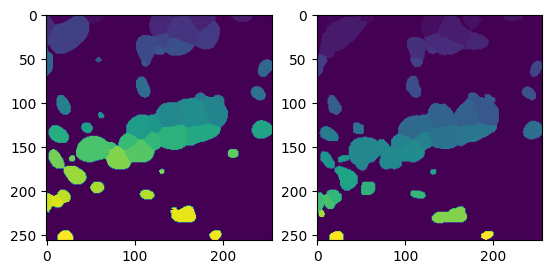

In [7]:
plt.subplot(1,2,1)
plt.imshow(masks[100])
plt.subplot(1,2,2)
plt.imshow(y_test[100,...,0])